In [1]:
import pyspark
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark import SparkContext
from pyspark.sql import SparkSession

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.sql.functions import isnan, when, count, col

from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.mllib.feature import Word2Vec

### Set Constraints

In [2]:
PATH = "Office_Products_5.json"
APP_NAME = "Amazon Sentiment Analysis"
SPARK_URL = "local[*]"
RANDOM_SEED = 141107
TRAINING_DATA_RATIO = 0.8

RF_NUM_TREES = 10
RF_MAX_DEPTH = 4
RF_NUM_BINS = 32

In [3]:
sc = SparkSession.builder.appName(APP_NAME).master(SPARK_URL).getOrCreate()
df = sc.read.options(inferschema = "true").json(PATH)

In [4]:
df.show(5)

+----------+-------+-------+--------------------+-----------+--------------+-------------------+--------------------+--------------+
|      asin|helpful|overall|          reviewText| reviewTime|    reviewerID|       reviewerName|             summary|unixReviewTime|
+----------+-------+-------+--------------------+-----------+--------------+-------------------+--------------------+--------------+
|B00000JBLH| [3, 4]|    5.0|I bought my first...| 09 3, 2004|A32T2H8150OJLU|                ARH|A solid performer...|    1094169600|
|B00000JBLH| [7, 9]|    5.0|WHY THIS BELATED ...|12 15, 2007|A3MAFS04ZABRGO|   Let it Be "Alan"|Price of GOLD is ...|    1197676800|
|B00000JBLH| [3, 3]|    2.0|I have an HP 48GX...| 01 1, 2011|A1F1A0QQP2XVH5|             Mark B|Good functionalit...|    1293840000|
|B00000JBLH| [7, 8]|    5.0|I've started doin...|04 19, 2006| A49R5DBXXQDE5|       R. D Johnson|One of the last o...|    1145404800|
|B00000JBLH| [0, 0]|    5.0|For simple calcul...| 08 4, 2013|A2XRMQA6

In [5]:
# Check size and shape of data
print(f"Data has {df.count():d} rows and {len(df.columns):d} columns")

# Check for missing
#df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

df.printSchema()

Data has 53258 rows and 9 columns
root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



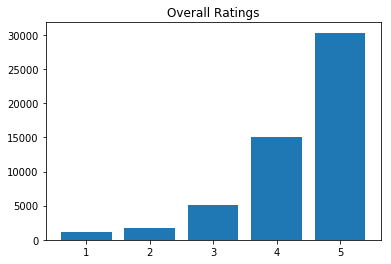

In [6]:
# Check out overall
sentiment_count = df.groupby('overall').count().collect()
x = [x[0] for x in sentiment_count]
ht = [ct[1] for ct in sentiment_count]

plt.bar(x, ht)
plt.title('Overall Ratings')
plt.show()

Try muliclass logistic regression with largely imbalanced classes, then try a binary situation where 4s and 5s equal good and 1-3 are bad.

In [7]:
from pyspark.sql.functions import concat, col, lit

# Combine the summary and review text into one column labelled corpus
df= df.withColumn('corpus', concat(col("summary"), lit(" "), col("reviewText")))
target = df.select('overall')
df[['corpus']].show(5)

# Dataframe of corpus and target
data = df.select("overall", "corpus")
data.show(5)

+--------------------+
|              corpus|
+--------------------+
|A solid performer...|
|Price of GOLD is ...|
|Good functionalit...|
|One of the last o...|
|Still the best Fo...|
+--------------------+
only showing top 5 rows

+-------+--------------------+
|overall|              corpus|
+-------+--------------------+
|    5.0|A solid performer...|
|    5.0|Price of GOLD is ...|
|    2.0|Good functionalit...|
|    5.0|One of the last o...|
|    5.0|Still the best Fo...|
+-------+--------------------+
only showing top 5 rows



In [8]:
# try sampling down to see if error is related to memory
small_data = data.sample(False,.8, seed=42)

In [9]:
# Instantiate, Tokenizer, HashingTF and transform corpus
# Tokenize corpus
tokenizer = Tokenizer(inputCol="corpus", outputCol="tokens")
tokenized_corpus = tokenizer.transform(data)

# Get term frequencies of tokens
hashingTF = HashingTF(inputCol='tokens', outputCol='raw_tf', numFeatures=1000)
tf_data = hashingTF.transform(tokenized_corpus)

# Calculate IDF for features
idf = IDF(inputCol="raw_tf", outputCol="features")
idfModel = idf.fit(tf_data)

tfidf_vectors = idfModel.transform(tf_data)

tfidf_vectors.select("overall", "features").show()

+-------+--------------------+
|overall|            features|
+-------+--------------------+
|    5.0|(1000,[4,5,36,39,...|
|    5.0|(1000,[1,5,6,8,10...|
|    2.0|(1000,[18,25,36,5...|
|    5.0|(1000,[2,6,8,13,1...|
|    5.0|(1000,[7,8,9,32,3...|
|    5.0|(1000,[0,1,8,18,2...|
|    5.0|(1000,[8,22,25,26...|
|    5.0|(1000,[8,18,23,36...|
|    5.0|(1000,[1,12,16,19...|
|    5.0|(1000,[121,219,24...|
|    5.0|(1000,[0,18,36,77...|
|    5.0|(1000,[4,18,36,37...|
|    5.0|(1000,[44,47,48,4...|
|    5.0|(1000,[1,15,36,38...|
|    4.0|(1000,[0,1,5,6,12...|
|    5.0|(1000,[36,39,105,...|
|    5.0|(1000,[4,15,18,28...|
|    5.0|(1000,[18,19,36,4...|
|    4.0|(1000,[76,82,140,...|
|    5.0|(1000,[13,18,48,7...|
+-------+--------------------+
only showing top 20 rows



In [10]:
# Example from Apache Spark Documentation

sentenceData = sc.createDataFrame([
    (0.0, "Hi I heard about Spark"),
    (0.0, "I wish Java could use case classes"),
    (1.0, "Logistic regression models are neat")
], ["label", "sentence"])

tokenizer = Tokenizer(inputCol="sentence", outputCol="words")
wordsData = tokenizer.transform(sentenceData)

hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=20)
featurizedData = hashingTF.transform(wordsData)
# alternatively, CountVectorizer can also be used to get term frequency vectors

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

rescaledData.select("label", "features").show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(20,[0,5,9,17],[0...|
|  0.0|(20,[2,7,9,13,15]...|
|  1.0|(20,[4,6,13,15,18...|
+-----+--------------------+



In [11]:
# Build the training indexers / split data / logistic regression classifier

# first we'll generate a labelIndexer
labelIndexer = StringIndexer(inputCol="overall", outputCol="indexedLabel").fit(tfidf_vectors)

# now generate the indexed feature vector
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(tfidf_vectors)
    
# Split the data into training and validation sets (30% held out for testing)
(trainingData, testData) = tfidf_vectors.randomSplit([TRAINING_DATA_RATIO, 1 - TRAINING_DATA_RATIO])

# Train a Logistic Regression model.
lr = LogisticRegression(labelCol="indexedLabel", featuresCol="indexedFeatures")

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=RF_NUM_TREES)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
pipelinelr = Pipeline(stages=[labelIndexer, featureIndexer, lr, labelConverter])
pipelinerf = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

In [12]:
# Train model.  This also runs the indexers.
model_lr = pipelinelr.fit(trainingData)
model_rf = pipelinerf.fit(trainingData)

# Make predictions.
predictionslr = model_lr.transform(testData)
predictionsrf = model_rf.transform(testData)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

accuracy_lr = evaluator.evaluate(predictionslr)
accuracy_rf = evaluator.evaluate(predictionsrf)

print(f"Test Error for Logistic = {(1.0 - accuracy_lr):g}\nAccuracy for Logistic = {accuracy_lr:g}")
print(f"Test Error for Forest = {(1.0 - accuracy_rf):g}\nAccuracy for Forest = {accuracy_rf:g}")

Test Error for Logistic = 0.385253
Accuracy for Logistic = 0.614747
Test Error for Forest = 0.432244
Accuracy for Forest = 0.567756


### Create Binary situation where 4s and 5s are good

In [13]:
# We need to set up user defined function to map the binary case to our target
# We will need to define the datatype when using user defined function

# Import udf and integer datatype
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import IntegerType

# If value greater than or equal to 4 replace with 1 else replace with -1, datatype = integer
udf = UserDefinedFunction(lambda x: 1 if x >= 4.0 else -1, IntegerType())

data = data.withColumn("overall_recode",udf(data.overall))
data.show(5)

+-------+--------------------+--------------+
|overall|              corpus|overall_recode|
+-------+--------------------+--------------+
|    5.0|A solid performer...|             1|
|    5.0|Price of GOLD is ...|             1|
|    2.0|Good functionalit...|            -1|
|    5.0|One of the last o...|             1|
|    5.0|Still the best Fo...|             1|
+-------+--------------------+--------------+
only showing top 5 rows



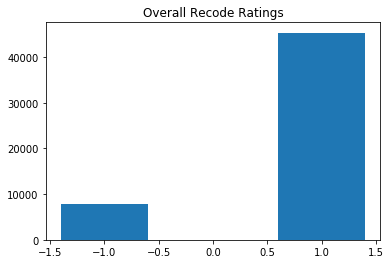

In [14]:
# Check out overall

# counts for pos(1) and neg(-1) reviews - returns RDD list
overall_count = data.groupby('overall_recode').count().collect()
x = [x[0] for x in overall_count]
ht = [ct[1] for ct in overall_count]

plt.bar(x, ht)
plt.title('Overall Recode Ratings')
plt.show()

In [15]:
# Build the training indexers / split data / logistic regression classifier

# Instantiate, Tokenizer, HashingTF and transform corpus
# Tokenize corpus

# Re run tokenizer to add overall_recode to dataframe
tokenizer = Tokenizer(inputCol="corpus", outputCol="tokens")
tokenized_corpus = tokenizer.transform(data)

# Get term frequencies of tokens
hashingTF = HashingTF(inputCol='tokens', outputCol='raw_tf', numFeatures=1000)
tf_data = hashingTF.transform(tokenized_corpus)

# Calculate IDF for features
idf = IDF(inputCol="raw_tf", outputCol="features")
idfModel = idf.fit(tf_data)

tfidf_vectors = idfModel.transform(tf_data)

tfidf_vectors.select("overall",'overall_recode', "features").show()

# first we'll generate a labelIndexer
labelIndexer = StringIndexer(inputCol="overall_recode", outputCol="indexedLabel").fit(tfidf_vectors)

# now generate the indexed feature vector
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(tfidf_vectors)
    
# Split the data into training and validation sets (30% held out for testing)
(trainingData, testData) = tfidf_vectors.randomSplit([TRAINING_DATA_RATIO, 1 - TRAINING_DATA_RATIO])

# Train a Logistic Regression model.
lr = LogisticRegression(labelCol="indexedLabel", featuresCol="indexedFeatures")

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=RF_NUM_TREES)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
pipelinelr = Pipeline(stages=[labelIndexer, featureIndexer, lr, labelConverter])
pipelinerf = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

+-------+--------------+--------------------+
|overall|overall_recode|            features|
+-------+--------------+--------------------+
|    5.0|             1|(1000,[4,5,36,39,...|
|    5.0|             1|(1000,[1,5,6,8,10...|
|    2.0|            -1|(1000,[18,25,36,5...|
|    5.0|             1|(1000,[2,6,8,13,1...|
|    5.0|             1|(1000,[7,8,9,32,3...|
|    5.0|             1|(1000,[0,1,8,18,2...|
|    5.0|             1|(1000,[8,22,25,26...|
|    5.0|             1|(1000,[8,18,23,36...|
|    5.0|             1|(1000,[1,12,16,19...|
|    5.0|             1|(1000,[121,219,24...|
|    5.0|             1|(1000,[0,18,36,77...|
|    5.0|             1|(1000,[4,18,36,37...|
|    5.0|             1|(1000,[44,47,48,4...|
|    5.0|             1|(1000,[1,15,36,38...|
|    4.0|             1|(1000,[0,1,5,6,12...|
|    5.0|             1|(1000,[36,39,105,...|
|    5.0|             1|(1000,[4,15,18,28...|
|    5.0|             1|(1000,[18,19,36,4...|
|    4.0|             1|(1000,[76,

In [16]:
# Train model.  This also runs the indexers.
model_lr = pipelinelr.fit(trainingData)
model_rf = pipelinerf.fit(trainingData)

# Make predictions.
predictionslr = model_lr.transform(testData)
predictionsrf = model_rf.transform(testData)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

accuracy_lr = evaluator.evaluate(predictionslr)
accuracy_rf = evaluator.evaluate(predictionsrf)

print(f"Test Error for Logistic = {(1.0 - accuracy_lr):g}\nAccuracy for Logistic = {accuracy_lr:g}")
print(f"Test Error for Forest = {(1.0 - accuracy_rf):g}\nAccuracy for Forest = {accuracy_rf:g}")

Test Error for Logistic = 0.142817
Accuracy for Logistic = 0.857183
Test Error for Forest = 0.150562
Accuracy for Forest = 0.849438


In [17]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

predictionAndLabels_lr = testData.rdd.map(lambda lp: (float(model_lr.predict(lp.features)), lp.overall_recode))
metrics = BinaryClassificationMetrics(predictionAndLabels_lr)

Traceback (most recent call last):
  File "/usr/local/spark/python/pyspark/cloudpickle.py", line 148, in dump
    return Pickler.dump(self, obj)
  File "/usr/local/lib/python3.6/pickle.py", line 409, in dump
    self.save(obj)
  File "/usr/local/lib/python3.6/pickle.py", line 476, in save
    f(self, obj) # Call unbound method with explicit self
  File "/usr/local/lib/python3.6/pickle.py", line 751, in save_tuple
    save(element)
  File "/usr/local/lib/python3.6/pickle.py", line 476, in save
    f(self, obj) # Call unbound method with explicit self
  File "/usr/local/spark/python/pyspark/cloudpickle.py", line 255, in save_function
    self.save_function_tuple(obj)
  File "/usr/local/spark/python/pyspark/cloudpickle.py", line 292, in save_function_tuple
    save((code, closure, base_globals))
  File "/usr/local/lib/python3.6/pickle.py", line 476, in save
    f(self, obj) # Call unbound method with explicit self
  File "/usr/local/lib/python3.6/pickle.py", line 736, in save_tuple
    sa

PicklingError: Could not serialize object: Py4JError: An error occurred while calling o405.__getstate__. Trace:
py4j.Py4JException: Method __getstate__([]) does not exist
	at py4j.reflection.ReflectionEngine.getMethod(ReflectionEngine.java:318)
	at py4j.reflection.ReflectionEngine.getMethod(ReflectionEngine.java:326)
	at py4j.Gateway.invoke(Gateway.java:272)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)



Need help with the dataframe to rdd pair (key-value pairs)